In [ ]:
# notebook by Steffen Finck, 2023
# for course: Elective Artificial Intelligence, Informatics Digital Innovation

In [1]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import top_k_accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
import scipy.stats as stats
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier

import nltk
import string
import re

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Loading and Data Cleaning

In [2]:
# restrict to a certain size, use nRows = None to read all data
nrows = None

# read train data set
df_train = pd.read_csv('Genre Classification Dataset/train_data.txt', sep=':::',\
                       engine='python', header=None, nrows=nrows)
# rename columns
df_train.rename(columns={0:'id', 1:'title', 2:'genre', 3:'description'}, inplace=True)
# make everything lower case and remove trailing whitespaces
df_train['description'] = df_train['description'].apply(lambda x: x.lower().strip())
df_train['genre'] = df_train['genre'].apply(lambda x: x.lower().strip())

# read test data set
df_test = pd.read_csv('Genre Classification Dataset/test_data_solution.txt', sep=':::',\
                       engine='python', header=None, nrows=nrows)
# rename columns
df_test.rename(columns={0:'id', 1:'title', 2:'genre', 3:'description'}, inplace=True)
# make everything lower case and remove trailing whitespaces
df_test['description'] = df_test['description'].apply(lambda x: x.lower().strip())
df_test['genre'] = df_test['genre'].apply(lambda x: x.lower().strip())

# keep a list of all genre
allGenres = list(set(df_test['genre']))


## Prepare Data for Learning Task

In [3]:
def clean_text(text):
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return text

In [4]:
df_train.loc[0,'description']

'listening in to a conversation between his doctor and parents, 10-year-old oscar learns what nobody has the courage to tell him. he only has a few weeks to live. furious, he refuses to speak to anyone except straight-talking rose, the lady in pink he meets on the hospital stairs. as christmas approaches, rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow oscar to live life and love to the full, in the company of his friends pop corn, einstein, bacon and childhood sweetheart peggy blue.'

In [5]:
df_train['clean text'] = df_train['description'].apply(lambda x: clean_text(x))
display(df_train.loc[0, 'clean text'])
df_test['clean text'] = df_test['description'].apply(lambda x:clean_text(x))

'listening conversation doctor parents year old oscar learns nobody courage tell weeks live furious refuses speak anyone except straight talking rose lady pink meets hospital stairs christmas approaches rose uses fantastical experiences professional wrestler imagination wit charm allow oscar live life love full company friends pop corn einstein bacon childhood sweetheart peggy blue'

## Setup for training and testing

In [6]:
def trainPipeline(pipe, data, labels):
    t0 = time.time()
    pipe.fit(data, labels)
    print('time required for training: {0:.4f}'.format(time.time()-t0))
    return pipe

def evaluateModel(pipe, train, test, trainlabels, testlabels):
    # evaluation train data
    predictTrain = pipe.predict(train)
    print('\nclassification report (train data)')
    print('==================================')
    print(classification_report(trainlabels, predictTrain, digits=4, zero_division=0))
    # evaluation test data
    predict = pipe.predict(test)
    predictProba = pipe.predict_proba(test)
    print('bas: {0:.4f}'.format(balanced_accuracy_score(testlabels, predict, adjusted=True)))     
    print('auc: {0:.4f}'.format(roc_auc_score(testlabels, predictProba, average='weighted', multi_class='ovo')))
    print('top-k: {0:.4f}'.format(top_k_accuracy_score(testlabels, predictProba, k=2)))
    print('\n')
    print('classification report')
    print('=====================')
    print(classification_report(testlabels, predict, digits=4, zero_division=0))
    # confusion matrix
    cm = confusion_matrix(testlabels, predict,labels=pipe.classes_)
    fig, ax = plt.subplots(1,1, figsize=(15,15))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    disp.plot(ax=ax, xticks_rotation='vertical', colorbar=False)
    plt.show()
    return None


### Tf-idf

In [7]:
embedding = CountVectorizer(stop_words=None, ngram_range=(1,1),\
                            strip_accents='unicode', max_features=10)

In [8]:
examples = ['this is a blue house','this is a red cat','the cat is in the red house']

out=embedding.fit_transform(examples)
out

<3x8 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [9]:
out.toarray()

array([[1, 0, 1, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 1, 1, 0, 1],
       [0, 1, 1, 1, 1, 1, 2, 0]], dtype=int64)

In [10]:
embedding.vocabulary_

{'this': 7,
 'is': 4,
 'blue': 0,
 'house': 2,
 'red': 5,
 'cat': 1,
 'the': 6,
 'in': 3}

In [11]:
embedding.inverse_transform(out)

[array(['this', 'is', 'blue', 'house'], dtype='<U5'),
 array(['this', 'is', 'red', 'cat'], dtype='<U5'),
 array(['is', 'house', 'red', 'cat', 'the', 'in'], dtype='<U5')]

In [12]:
embedding = TfidfVectorizer(use_idf=True, stop_words=None, ngram_range=(1,1),\
                            max_df=1., min_df=0, smooth_idf=False, sublinear_tf=False,\
                            strip_accents='unicode', max_features=10, norm=None)

In [13]:
examples = ['this is a blue house','this is a red cat','the cat is in the red house']

out=embedding.fit_transform(examples)
out

<3x8 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [14]:
out.toarray()

array([[2.09861229, 0.        , 1.40546511, 0.        , 1.        ,
        0.        , 0.        , 1.40546511],
       [0.        , 1.40546511, 0.        , 0.        , 1.        ,
        1.40546511, 0.        , 1.40546511],
       [0.        , 1.40546511, 1.40546511, 2.09861229, 1.        ,
        1.40546511, 4.19722458, 0.        ]])

In [15]:
embedding.vocabulary_

{'this': 7,
 'is': 4,
 'blue': 0,
 'house': 2,
 'red': 5,
 'cat': 1,
 'the': 6,
 'in': 3}

In [16]:
embedding.inverse_transform(out)

[array(['house', 'blue', 'is', 'this'], dtype='<U5'),
 array(['cat', 'red', 'is', 'this'], dtype='<U5'),
 array(['in', 'the', 'cat', 'red', 'house', 'is'], dtype='<U5')]

In [17]:
# example for blue
ndocs = 3
occInDoc = 1
docsWithT = 1
occInDoc*(np.log(ndocs/docsWithT)+1)

2.09861228866811

## Random Forrest Classifier

time required for training: 123.4465

classification report (train data)
              precision    recall  f1-score   support

      action     1.0000    1.0000    1.0000      1315
       adult     1.0000    1.0000    1.0000       590
   adventure     0.9987    1.0000    0.9994       775
   animation     0.9960    0.9980    0.9970       498
   biography     1.0000    1.0000    1.0000       265
      comedy     0.9993    0.9988    0.9991      7447
       crime     1.0000    1.0000    1.0000       505
 documentary     1.0000    0.9997    0.9998     13096
       drama     0.9996    0.9993    0.9994     13613
      family     0.9924    1.0000    0.9962       784
     fantasy     0.9878    1.0000    0.9938       323
   game-show     1.0000    1.0000    1.0000       194
     history     1.0000    1.0000    1.0000       243
      horror     1.0000    1.0000    1.0000      2204
       music     1.0000    1.0000    1.0000       731
     musical     1.0000    1.0000    1.0000       277
     mys

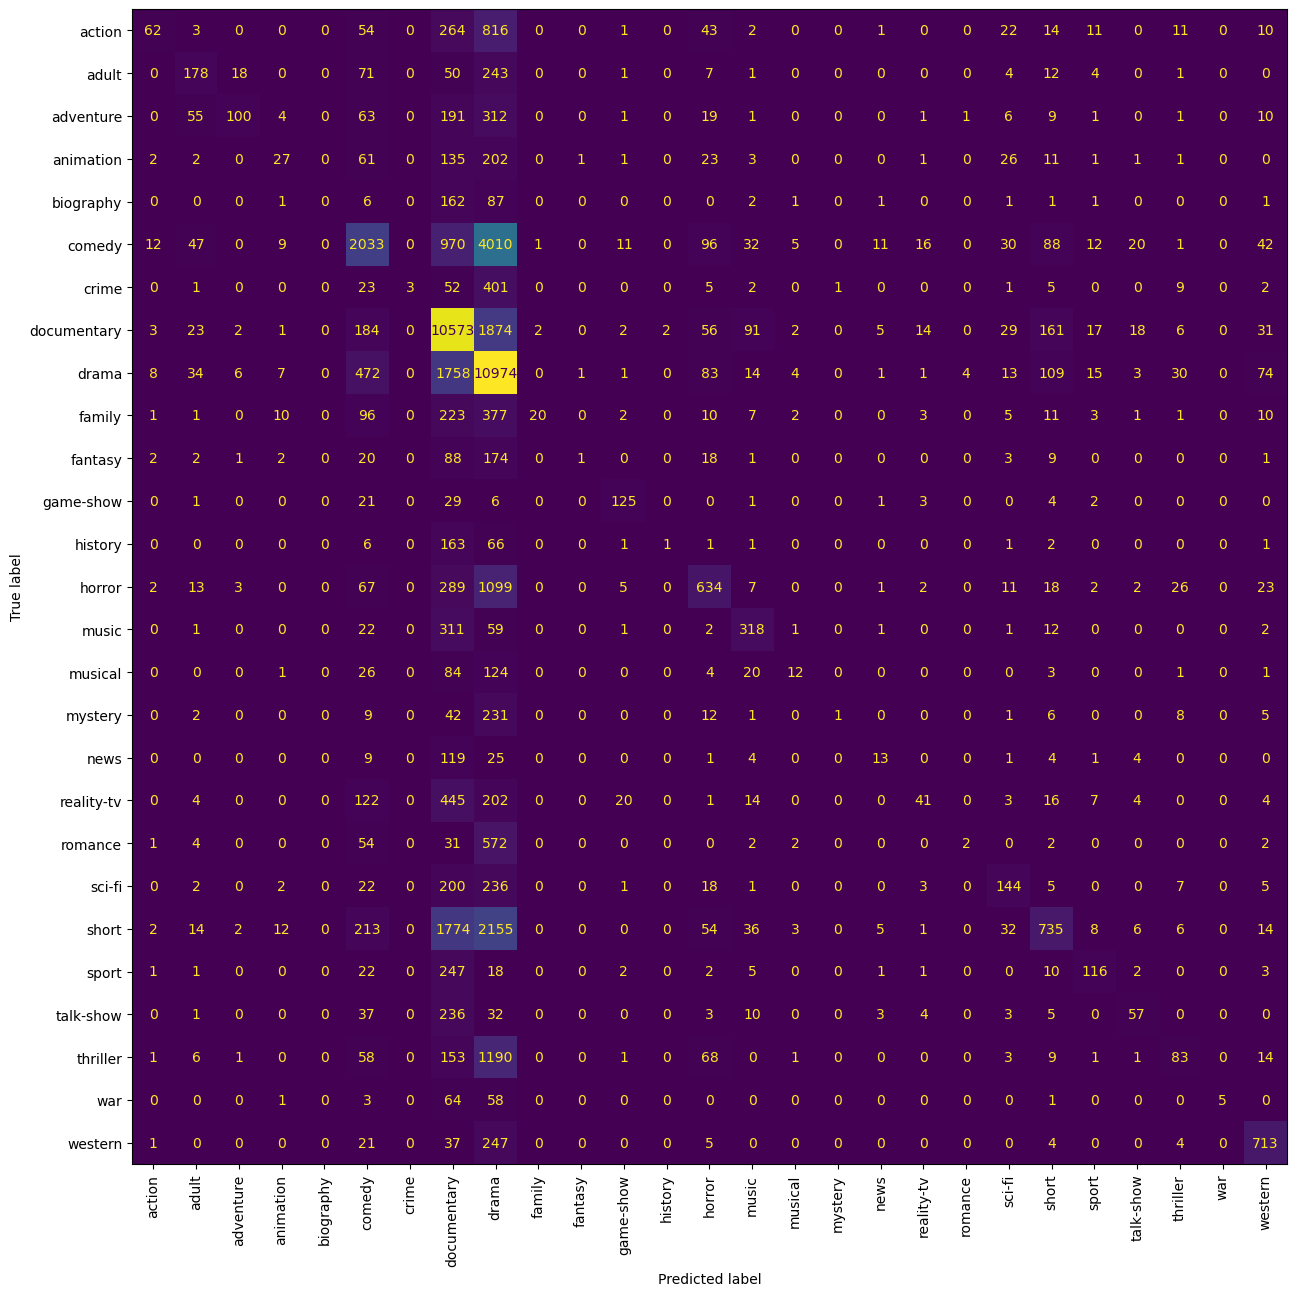

In [17]:
pipe1 = Pipeline([('tfidf', TfidfVectorizer(use_idf=True, stop_words='english', ngram_range=(1,2),\
                                            max_df=0.85, min_df=1, smooth_idf=True, norm='l2',\
                                            strip_accents='unicode', max_features=10000)),\
                   ('rf', RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2,\
                                                 min_samples_leaf=1, max_features='sqrt', \
                                                 bootstrap=True, n_jobs=-1, random_state=12, verbose=0,\
                                                 class_weight='balanced'))])

# fit training data to the pipelines
trainPipeline(pipe1, df_train['clean text'], df_train['genre'])
# evaluate model
evaluateModel(pipe1, df_train['clean text'], df_test['clean text'], df_train['genre'], df_test['genre'])

## Naive Bayes Classifier

time required for training: 17.7374

classification report (train data)
              precision    recall  f1-score   support

      action     0.5674    0.3521    0.4345      1315
       adult     0.7500    0.3407    0.4685       590
   adventure     0.7083    0.1974    0.3088       775
   animation     0.8082    0.1185    0.2067       498
   biography     1.0000    0.0038    0.0075       265
      comedy     0.5924    0.5751    0.5836      7447
       crime     0.7647    0.0257    0.0498       505
 documentary     0.5960    0.9248    0.7249     13096
       drama     0.5803    0.7610    0.6585     13613
      family     0.6774    0.0536    0.0993       784
     fantasy     0.7083    0.0526    0.0980       323
   game-show     0.6632    0.6598    0.6615       194
     history     0.5000    0.0041    0.0082       243
      horror     0.5602    0.7223    0.6310      2204
       music     0.5679    0.2517    0.3488       731
     musical     0.5000    0.0217    0.0415       277
     myst

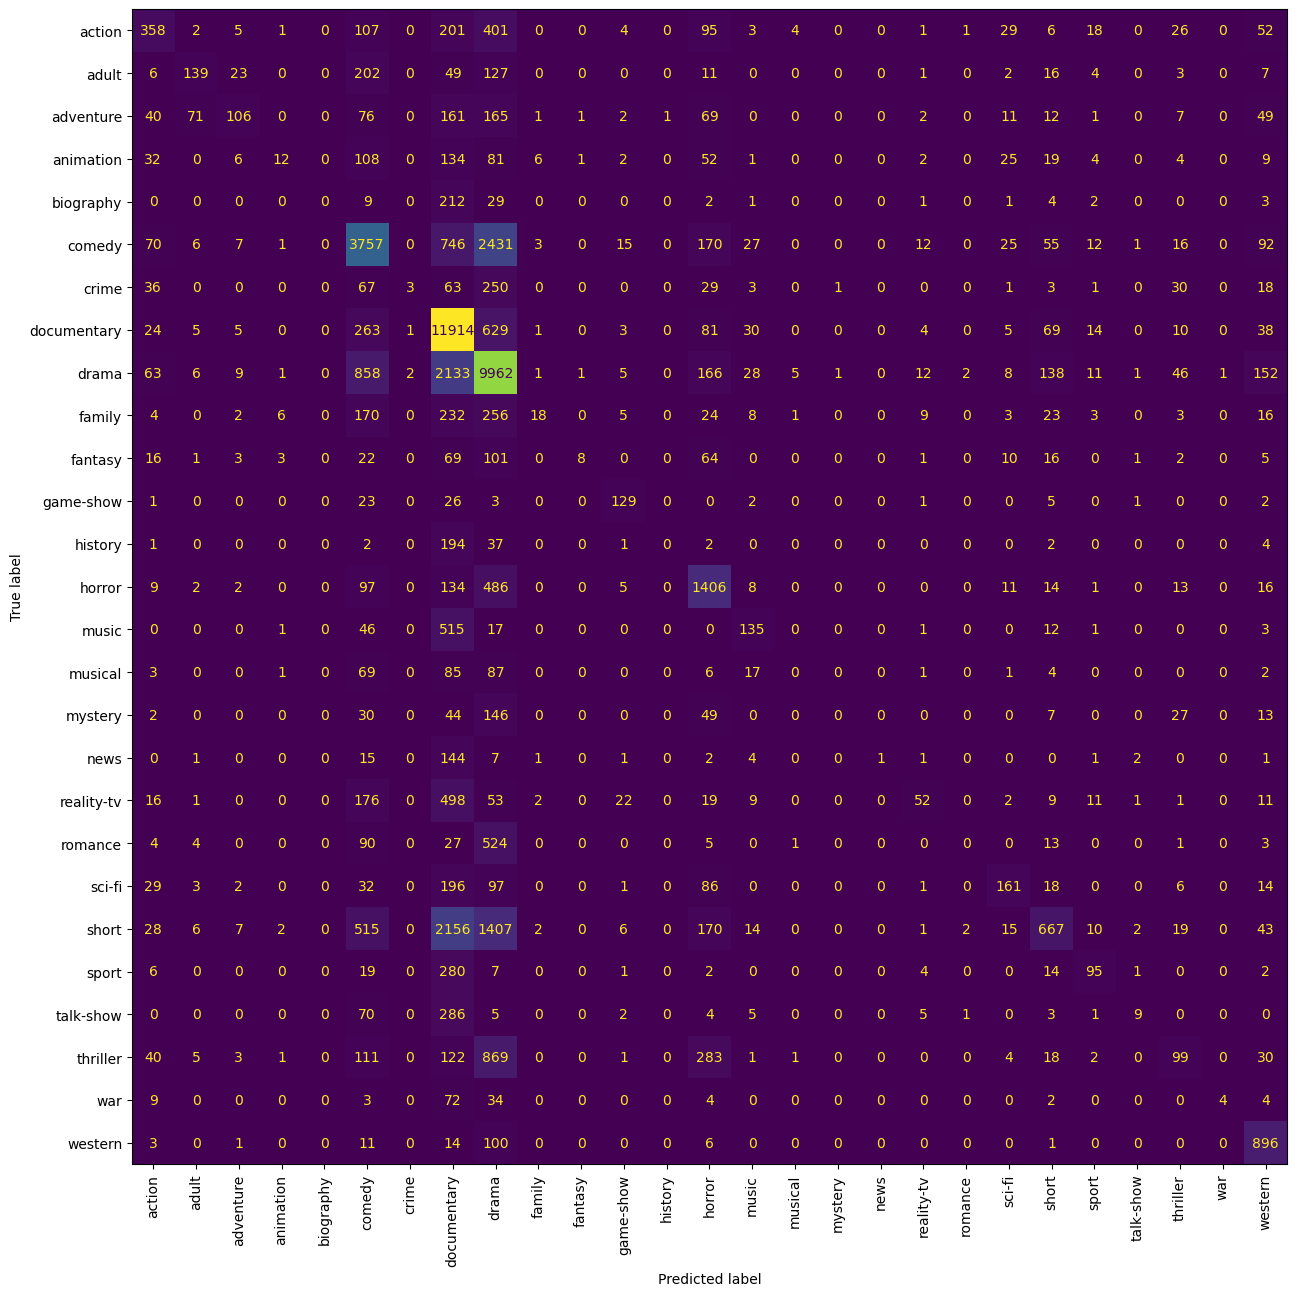

In [18]:
pipe2 = Pipeline([('tfidf', TfidfVectorizer(use_idf=True, stop_words='english', ngram_range=(1,2),\
                                            max_df=0.85, min_df=1, smooth_idf=False, sublinear_tf=True,\
                                            strip_accents='unicode', max_features=10000)),\
                 ('cnb', ComplementNB(alpha=0.5, force_alpha=False))])

# fit training data to the pipelines
trainPipeline(pipe2, df_train['clean text'],  df_train['genre'])
# evaluate model
evaluateModel(pipe2, df_train['clean text'], df_test['clean text'], df_train['genre'], df_test['genre'])

## Hyperparameter Optimization

In [21]:
pipe1.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(max_df=0.85, max_features=10000, ngram_range=(1, 2),
                   stop_words='english', strip_accents='unicode')),
  ('rf',
   RandomForestClassifier(class_weight='balanced', max_features='sqrt', n_jobs=-1,
                          random_state=12))],
 'verbose': False,
 'tfidf': TfidfVectorizer(max_df=0.85, max_features=10000, ngram_range=(1, 2),
                 stop_words='english', strip_accents='unicode'),
 'rf': RandomForestClassifier(class_weight='balanced', max_features='sqrt', n_jobs=-1,
                        random_state=12),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 0.85,
 'tfidf__max_features': 10000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 '

In [ ]:
# be careful: executing the cell can take a long time and yield to out-of-memory situations

paramGrid = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),  
    'tfidf__norm': ('l1', 'l2'),
    'tfidf__max_features': (2000,5000),
    'rf__n_estimators': (100,1000,5000)
}

gsSearch = HalvingGridSearchCV(estimator=pipe1, param_grid=paramGrid, n_jobs=-1, cv=3, verbose=1,\
                               scoring='balanced_accuracy', return_train_score=True, random_state=42,\
                               min_resources='exhaust', refit=True)

trainPipeline(gsSearch, df_train['clean text'], df_train['genre'])
print('\nBest parameters combination found:')
best_parameters = gsSearch.best_estimator_.get_params()
for param_name in sorted(paramGrid.keys()):
    print('{0}: {1}'.format(param_name, best_parameters[param_name]))
evaluateModel(gsSearch.best_estimator_, df_train['clean text'], df_test['clean text'],\
              df_train['genre'], df_test['genre'])